In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.5 MB/s eta 0:00:00


In [3]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# Dataset

In [4]:
set_config(transform_output="pandas")

In [5]:
# load the data

data = fetch_california_housing(as_frame=True)

In [6]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [7]:
# make X and y

X, y = data.data, data.target

In [8]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [9]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
y.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [11]:
X.shape

(20640, 8)

In [12]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


# Model

In [13]:
# model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

In [14]:
# fit the training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.05, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [15]:
# claculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


# HP Tuning

In [16]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    # set the model with the parameters
    model = XGBRegressor()

    model.set_params(**params)

    # fit the model
    model.fit(X_train, y_train)

    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [17]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2026-02-06 10:49:40,598] A new study created in memory with name: no-name-be92de89-e141-4873-9c4e-e45e119b7259


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-06 10:49:42,788] Trial 1 finished with value: 0.802358332039344 and parameters: {'learning_rate': 0.05100778123447073, 'n_estimators': 74, 'max_depth': 10, 'reg_lambda': 83.46860124216055, 'gamma': 1.0965706869118128, 'subsample': 0.9685344201299582}. Best is trial 1 with value: 0.802358332039344.
[I 2026-02-06 10:49:43,069] Trial 0 finished with value: 0.8440663527918062 and parameters: {'learning_rate': 0.2592390912187255, 'n_estimators': 94, 'max_depth': 9, 'reg_lambda': 75.62949681826316, 'gamma': 0.12385602418206343, 'subsample': 0.7221350124786089}. Best is trial 0 with value: 0.8440663527918062.
[I 2026-02-06 10:49:44,625] Trial 2 finished with value: 0.783185546468881 and parameters: {'learning_rate': 0.0220426626868344, 'n_estimators': 158, 'max_depth': 7, 'reg_lambda': 37.158092569595716, 'gamma': 0.05506610834803061, 'subsample': 0.979912547856504}. Best is trial 0 with value: 0.8440663527918062.
[I 2026-02-06 10:49:46,200] Trial 4 finished with value: 0.837905236

In [18]:
# get the best parameters
study.best_params

{'learning_rate': 0.2016193932848298,
 'n_estimators': 390,
 'max_depth': 6,
 'reg_lambda': 37.21955856021974,
 'gamma': 0.1043884264410533,
 'subsample': 0.90505841815727}

In [19]:
# get the best value
study.best_value

0.8522848603723103

In [20]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1043884264410533, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2016193932848298, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=390, n_jobs=None,
             num_parallel_tree=None, ...)

In [21]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2615, R2: 0.9488
Test RMSE: 0.4440, R2: 0.8496


# SHAP

In [22]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1043884264410533, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2016193932848298, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=390, n_jobs=None,
             num_parallel_tree=None, ...)

In [23]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [24]:
# expected value
explainer.expected_value

np.float64(2.0198650974445354)

In [25]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

 99%|===================| 4099/4128 [01:19<00:00]       

In [26]:
shap_values.shape

(4128, 8)

In [27]:
len(feature_names)

8

In [28]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [29]:
shap_values[0:5]

.values =
array([[-3.33170315e-01,  7.40864686e-03, -1.59234081e-01,
         9.65359180e-03, -2.06903996e-02, -2.09877227e-01,
        -7.36304210e-01, -5.90405766e-02],
       [-2.92397066e-01,  7.12023981e-03, -8.22474558e-02,
         3.54713335e-03, -1.65147667e-03, -8.18896449e-02,
        -8.78880684e-01,  4.36716947e-02],
       [ 2.04196086e-01,  3.78424873e-01, -1.28982581e-01,
         1.19893288e-01, -3.84999745e-02,  8.79363978e-01,
         7.87194927e-02,  1.77456114e+00],
       [ 3.80606336e-01,  8.91348094e-03,  1.89251004e-01,
         1.44226627e-02,  2.88524855e-04, -3.28126487e-01,
         1.28138465e-01,  6.99798099e-02],
       [-8.62447321e-02,  2.33150690e-02, -2.10294344e-02,
         3.02080370e-02, -5.18739801e-03,  8.32542986e-03,
        -4.99696066e-01,  9.74122222e-01]])

.base_values =
array([2.0198651, 2.0198651, 2.0198651, 2.0198651, 2.0198651])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e

In [30]:
X_test.head(1).values

array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02]])

# GLOBAL PLOTS

In [31]:
shap_values

.values =
array([[-0.33317032,  0.00740865, -0.15923408, ..., -0.20987723,
        -0.73630421, -0.05904058],
       [-0.29239707,  0.00712024, -0.08224746, ..., -0.08188964,
        -0.87888068,  0.04367169],
       [ 0.20419609,  0.37842487, -0.12898258, ...,  0.87936398,
         0.07871949,  1.77456114],
       ...,
       [ 1.44820832,  0.0126016 ,  0.55490294, ...,  0.0305602 ,
        -0.07665617,  1.01380343],
       [-0.18136378, -0.03161797, -0.05143999, ...,  0.00762039,
        -1.04112236,  0.01040295],
       [-0.06990005, -0.01479156, -0.28397304, ..., -0.31776094,
         0.21651733,  0.08333484]])

.base_values =
array([2.0198651, 2.0198651, 2.0198651, ..., 2.0198651, 2.0198651,
       2.0198651])

.data =
array([[   1.6812    ,   25.        ,    4.19220056, ...,    3.87743733,
          36.06      , -119.01      ],
       [   2.5313    ,   30.        ,    5.03938356, ...,    2.67979452,
          35.14      , -119.46      ],
       [   3.4801    ,   52.        ,    3

In [32]:
shap_values.shape

(4128, 8)

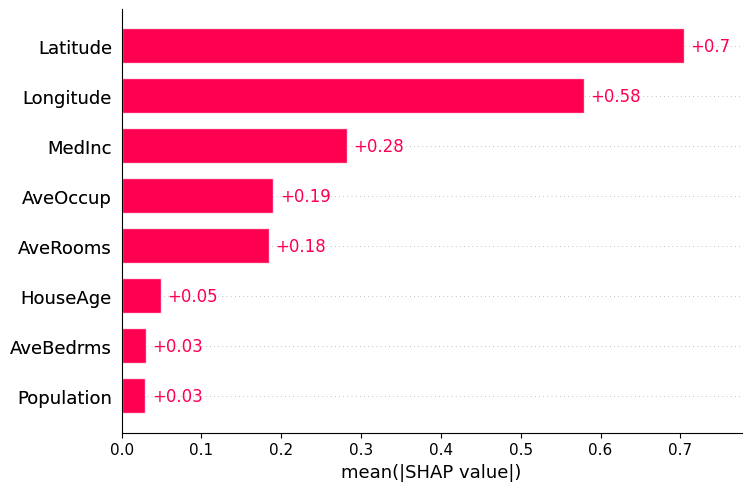

In [33]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

In [34]:
shap_values.abs.mean(axis=0)

.values =
array([0.28219858, 0.04950042, 0.18408167, 0.03072728, 0.02949488,
       0.19004531, 0.70439629, 0.57902439])

.base_values =
np.float64(2.019865097444536)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

In [35]:
shap_values.abs.mean(axis=0).values

array([0.28219858, 0.04950042, 0.18408167, 0.03072728, 0.02949488,
       0.19004531, 0.70439629, 0.57902439])

In [36]:
dict(zip(feature_names,shap_values.abs.mean(axis=0).values))

{'MedInc': np.float64(0.28219858289277167),
 'HouseAge': np.float64(0.049500418614976366),
 'AveRooms': np.float64(0.18408166919304653),
 'AveBedrms': np.float64(0.030727275901105956),
 'Population': np.float64(0.029494880655131075),
 'AveOccup': np.float64(0.19004531093844873),
 'Latitude': np.float64(0.704396293386179),
 'Longitude': np.float64(0.5790243901365604)}

In [37]:
feature_importances = {feature:shap_val.item() for feature, shap_val in
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

In [38]:
feature_importances

{'MedInc': 0.28219858289277167,
 'HouseAge': 0.049500418614976366,
 'AveRooms': 0.18408166919304653,
 'AveBedrms': 0.030727275901105956,
 'Population': 0.029494880655131075,
 'AveOccup': 0.19004531093844873,
 'Latitude': 0.704396293386179,
 'Longitude': 0.5790243901365604}

In [39]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'AveBedrms',
 'Population']

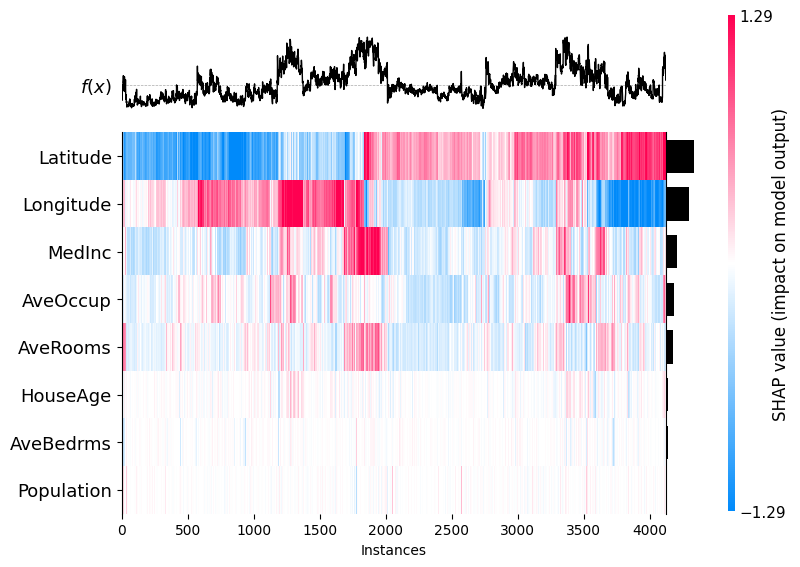

<Axes: xlabel='Instances'>

In [40]:
# heatmap plot

shap.plots.heatmap(shap_values)

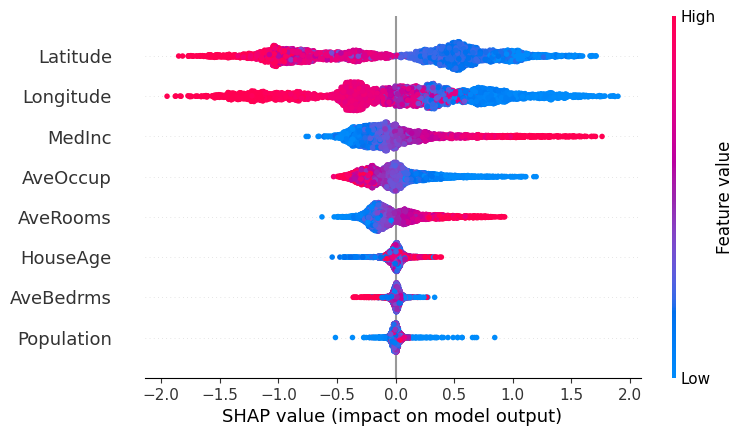

In [41]:
# summary plot

shap.plots.beeswarm(shap_values)

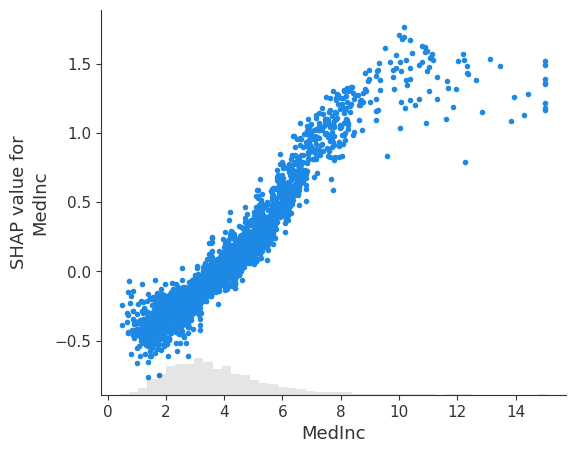

In [42]:
# scatter plot (Dependence Plot)
shap.plots.scatter(shap_values[:, "MedInc"])

In [43]:
shap_values[:, "Latitude"]

.values =
array([-0.73630421, -0.87888068,  0.07871949, ..., -0.07665617,
       -1.04112236,  0.21651733])

.base_values =
array([2.0198651, 2.0198651, 2.0198651, ..., 2.0198651, 2.0198651,
       2.0198651])

.data =
array([36.06, 35.14, 37.8 , ..., 37.31, 36.77, 34.22])

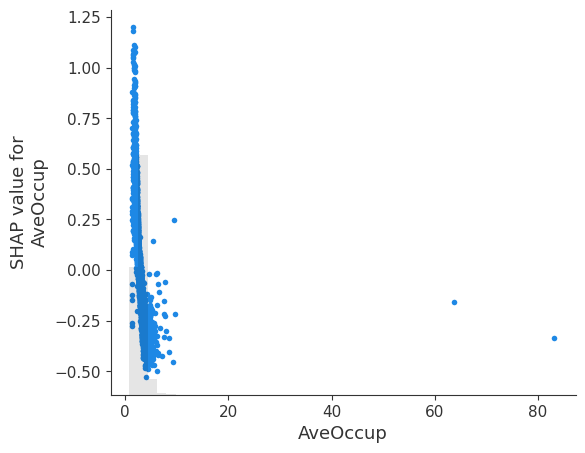

In [44]:
shap.plots.scatter(shap_values[:, "AveOccup"])

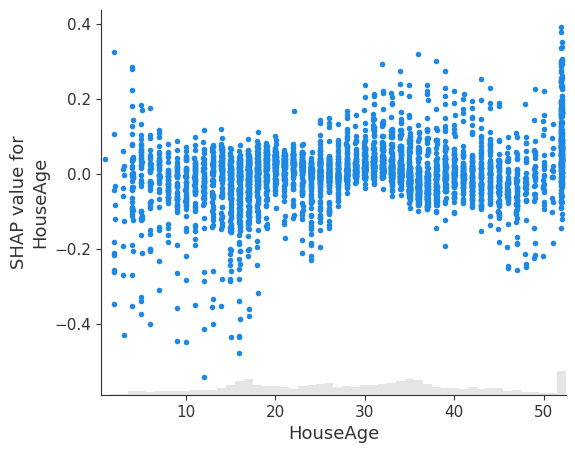

In [45]:
shap.plots.scatter(shap_values[:, "HouseAge"])

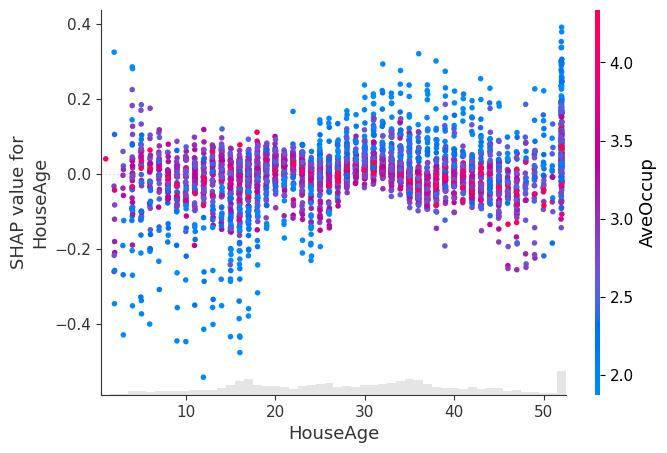

In [46]:
# scatter plot with interaction

shap.plots.scatter(shap_values[:, "HouseAge"], color=shap_values)

# LOCAL PLOTS

In [47]:
test_case = X_test.sample(1)

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
17681,2.3715,18.0,3.421338,1.027125,974.0,1.761302,37.29,-121.87


In [48]:
explained_row = explainer(test_case)

explained_row

.values =
array([[-0.27760098, -0.0464101 , -0.24448687,  0.01956406, -0.02299315,
         0.35729155, -0.43215168,  0.73594122]])

.base_values =
array([2.0198651])

.data =
array([[   2.3715    ,   18.        ,    3.42133816,    1.02712477,
         974.        ,    1.76130199,   37.29      , -121.87      ]])

In [49]:
explained_row[0,:].shape

(8,)

In [50]:
explained_row.shape

(1, 8)

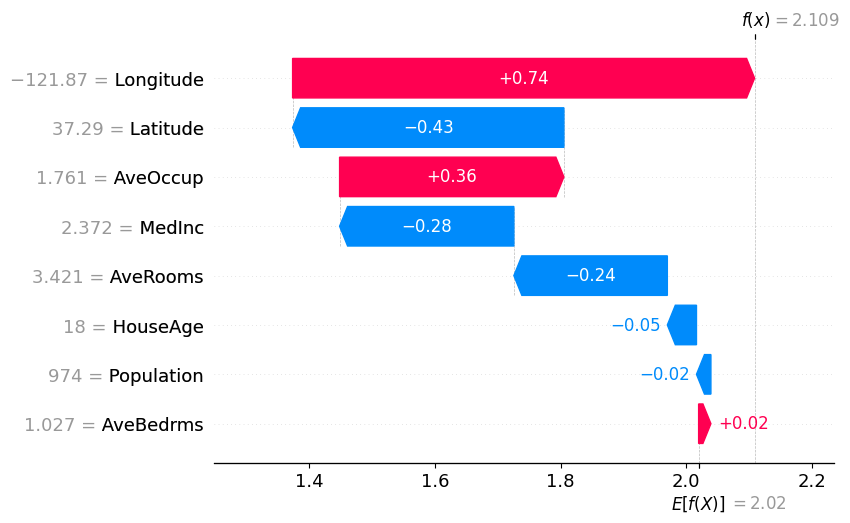

In [51]:
# waterfall plot

shap.plots.waterfall(explained_row[0])

In [52]:
# force plot

shap.plots.initjs()

shap.plots.force(explained_row[0])

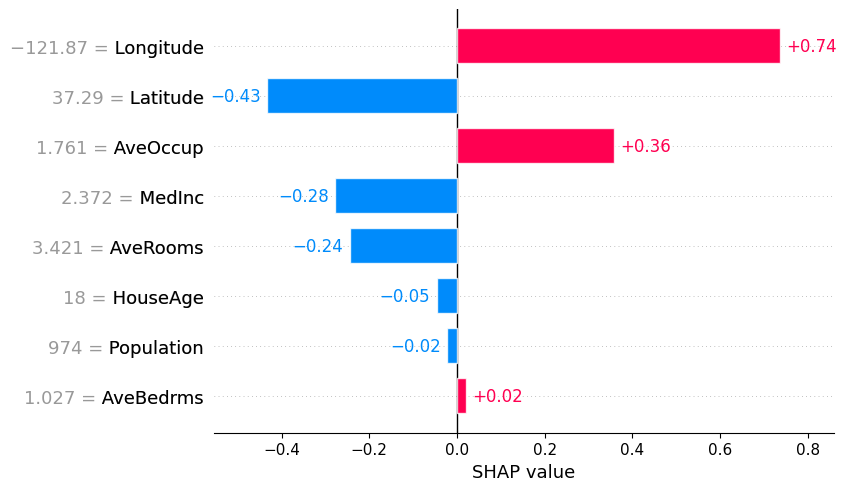

In [53]:
# bar plot for local explaination

shap.plots.bar(explained_row[0])

# LIME

In [54]:
# test case

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
17681,2.3715,18.0,3.421338,1.027125,974.0,1.761302,37.29,-121.87


In [55]:
# convert test case to a 1D array

test_case_lime = test_case.values.flatten()

In [57]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=53f18c5121e51a5159c281158bac82693e98cdd30a2f0df4b525859cb9d8869c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [58]:
from lime.lime_tabular import LimeTabularExplainer

In [59]:
X_train.values.shape

(16512, 8)

In [60]:
# feature names

feature_names = X_train.columns.tolist()

In [61]:
# make an lime explainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="regression",
    feature_names=feature_names
)

In [62]:
# get the lime explanations

lime_explanation = lime_explainer.explain_instance(
    data_row=test_case_lime,
    predict_fn=xgb_model.predict
)

In [63]:
# lime explanations --> list of values

lime_explanation.as_list()

[('Longitude <= -121.81', 0.824058532802907),
 ('MedInc <= 2.57', -0.5379698819969218),
 ('34.26 < Latitude <= 37.72', -0.5071037255505007),
 ('AveOccup <= 2.43', 0.3881362852274007),
 ('AveRooms <= 4.45', -0.33533726171001177),
 ('HouseAge <= 18.00', -0.09851169690132476),
 ('1.01 < AveBedrms <= 1.05', -0.045896454242836976),
 ('789.00 < Population <= 1167.00', 0.00884988615965511)]

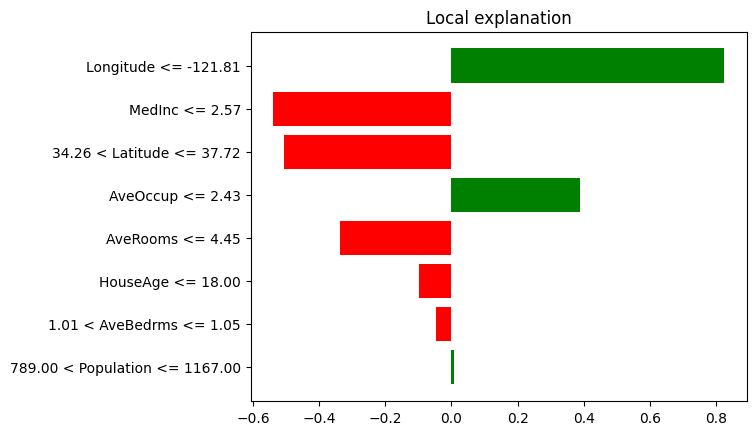

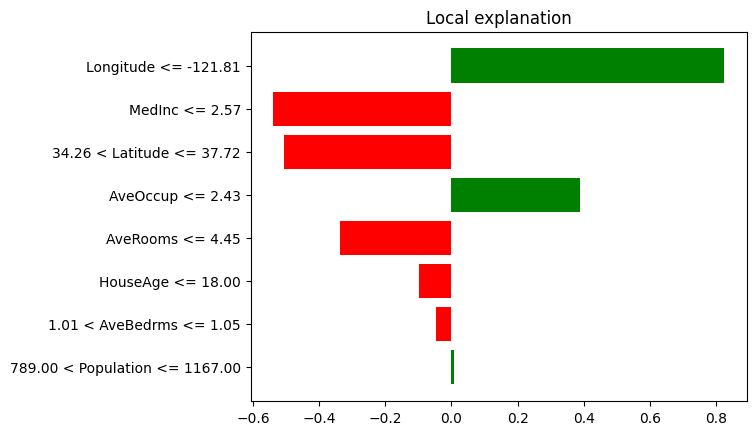

In [64]:
# lime explanations --> pyplot figure

lime_explanation.as_pyplot_figure()

In [65]:
# lime explanations --> as html

from IPython.core.display import HTML

In [66]:
xgb_model.predict(test_case)

array([1.9732649], dtype=float32)

In [67]:
# display explanation

display(HTML(lime_explanation.as_html()))
